In [12]:
import os
import pathlib

import numpy as np
import pandas as pd

import re

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["use_mathtext", "colors10"])

DIR_HOME = pathlib.Path("..").absolute()
DIR_EVAL = DIR_HOME / "data" / "evaluations"

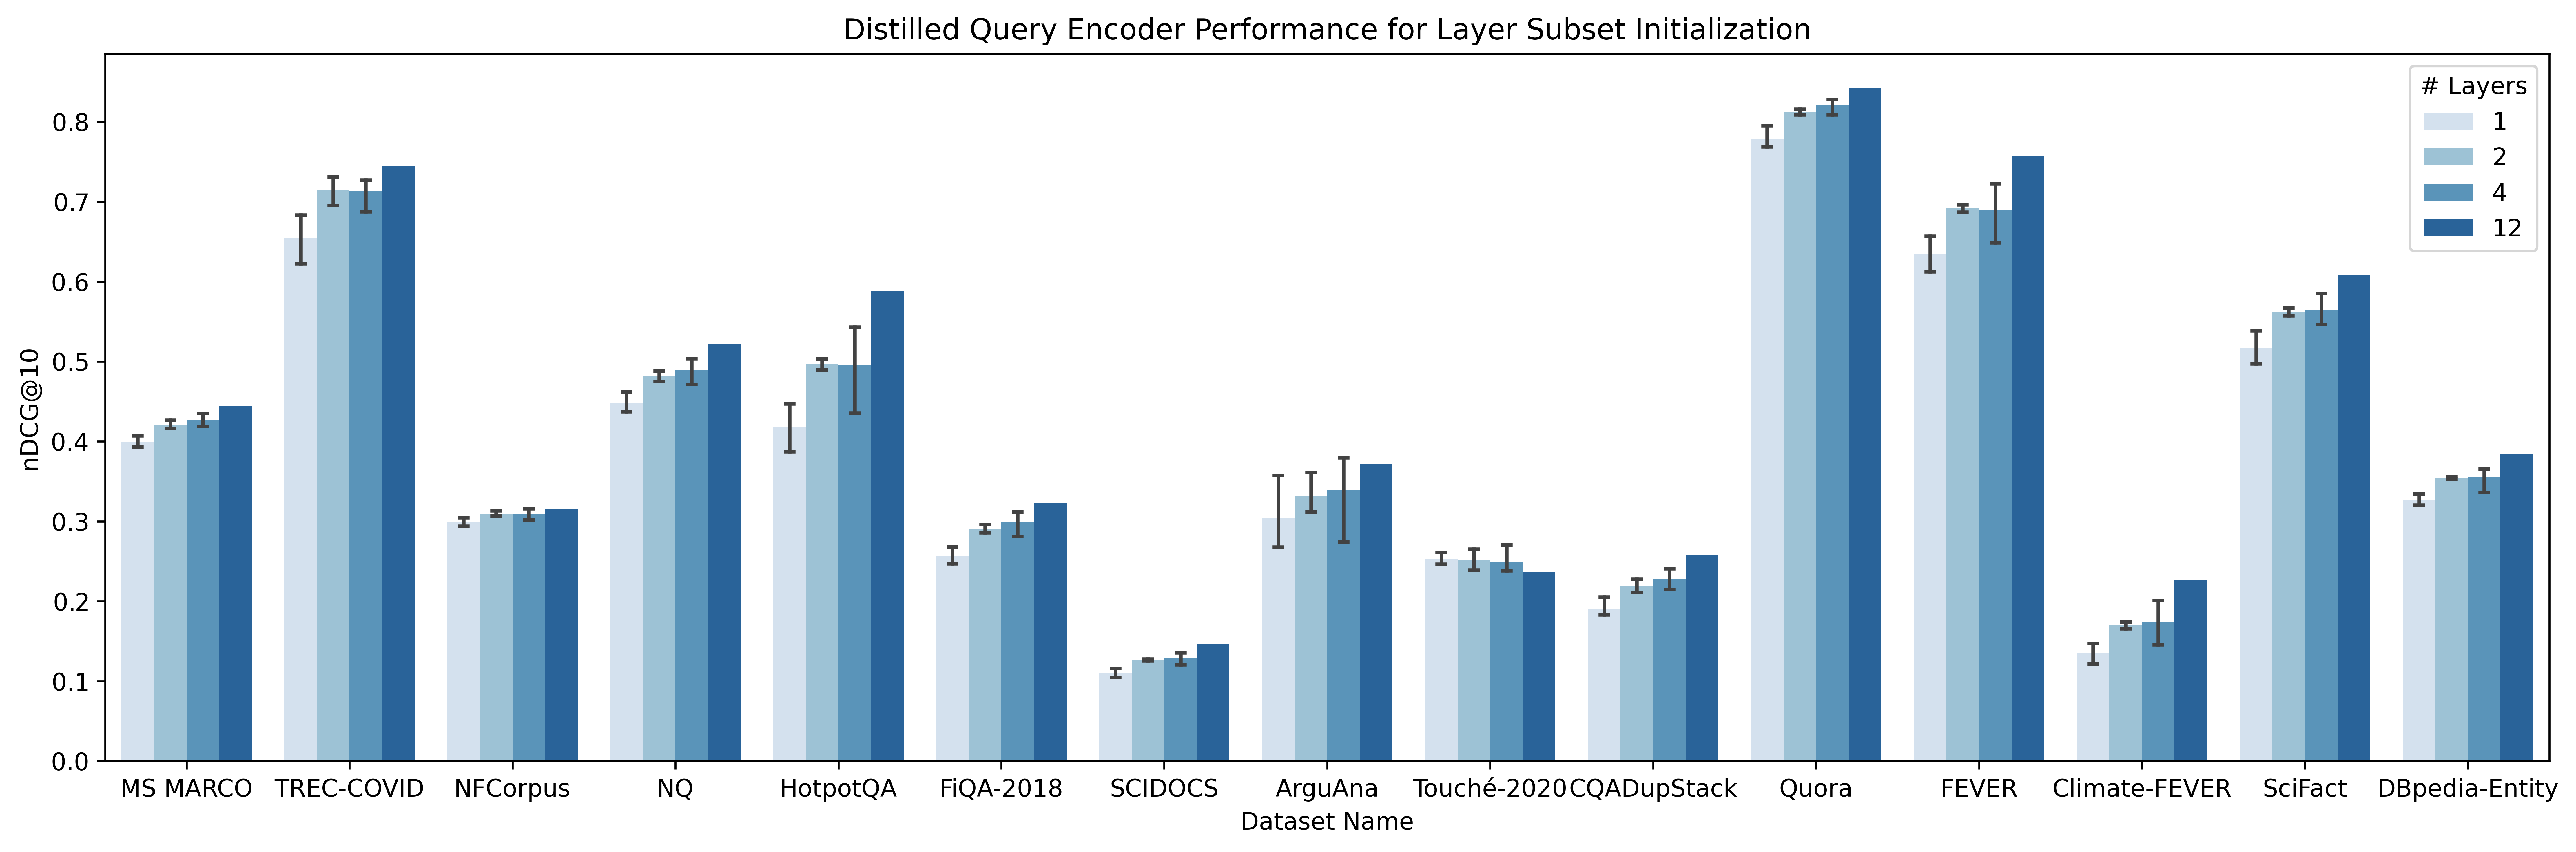

In [8]:
def get_num_layers(x) -> str:

    import re

    pattern = re.compile(r"basemodel_(\d+)layer")
    match = pattern.search(x)
    if match:
        return int(match.group(1))
    return 12


def get_ds_name(x) -> str:
    table = {
        "msmarco":          "MS MARCO",
        "webis-touche2020": "Touché-2020",
        "fiqa":             "FiQA-2018",
        "trec-covid":       "TREC-COVID",
        "nfcorpus":         "NFCorpus",
        "nq":               "NQ",
        "quora":            "Quora",
        "scifact":          "SciFact",
        "scidocs":          "SCIDOCS",
        "arguana":          "ArguAna",
        "dbpedia-entity":   "DBpedia-Entity",
        "cqadupstack":      "CQADupStack",
        "climate-fever":    "Climate-FEVER",
        "fever":            "FEVER",
        "hotpotqa":         "HotpotQA",
    }
    return table[x]


df_extract = pd.read_csv(DIR_EVAL / "eval_results_extract.csv")
df_extract["n_layers"] = df_extract["query_encoder"].map(get_num_layers)
df_extract["dataset_name"] = df_extract["dataset_name"].map(get_ds_name)

fig, ax = plt.subplots(figsize=(15, 5), dpi=600)
barplot = sns.barplot(data=df_extract,
                      x="dataset_name",
                      y="NDCG@10",
                      errorbar=lambda x: (x.min(), x.max()),
                      hue="n_layers",
                      palette=sns.color_palette("Blues", n_colors=df_extract["n_layers"].nunique()),
                      capsize=.05,
                      errwidth=1.5,
                      orient="v",
                      ax=ax)

ax.set_title("Distilled Query Encoder Performance for Layer Subset Initialization")
ax.set_xlabel("Dataset Name")
ax.set_ylabel("nDCG@10")
ax.legend(title="# Layers")

fig.tight_layout()

In [29]:
# Examine layer selection differences
ns = [1, 2, 4]
fig, axs = plt.subplots(3, 1, figsize=(24, 12), dpi=600)

for ax, n in zip(axs, ns):
    pattern = f"^basemodel_{n}layer|msmarco-bert-base-dot-v5" 
    mask = df_extract["query_encoder"].map(lambda s: len(re.findall(pattern, s)) > 0)

    df_vis = df_extract[mask].copy()
    df_vis["query_encoder"] = df_vis["query_encoder"].map(lambda s: s.replace(f"basemodel_{n}layer_", "layer_").replace("_", "-"))
    df_avg = df_vis.filter(regex=r"query_encoder|@") \
                .groupby(["query_encoder"]) \
                .mean() \
                .reset_index() \
                .assign(dataset_name="Average") \
                .sort_values("NDCG@10", ascending=True)

    
    barplot = sns.barplot(data=df_vis,
                        x="dataset_name",
                        y="NDCG@10",
                        hue="query_encoder",
                        hue_order=df_avg["query_encoder"],
                        orient="v",
                        ax=ax)

    ax.set_title(f"nDCG@10 for {n} Teacher Layer(s) Initialization")
    ax.set_xlabel("Dataset Name")
    ax.set_ylabel("nDCG@10")
    ax.legend(title="Selections")

fig.tight_layout()

In [5]:
# Join 1-layer and 12-layer results to compare performance drop
df_join = df_extract.copy()
df_join["query_encoder"] = df_join["query_encoder"].str.replace("basemodel_2layer_0_11", "2-layer")
df_join["query_encoder"] = df_join["query_encoder"].str.replace("msmarco-bert-base-dot-v5", "12-layer")

df_join = pd.merge(df_join[df_join["query_encoder"] == "2-layer"],
            df_join[df_join["query_encoder"] == "12-layer"],
            on=["dataset_name"],
            suffixes=["_1", "_12"])
((df_join["NDCG@10_1"] - df_join["NDCG@10_12"]) / df_join["NDCG@10_12"] * 100).mean()

-7.016548463701655

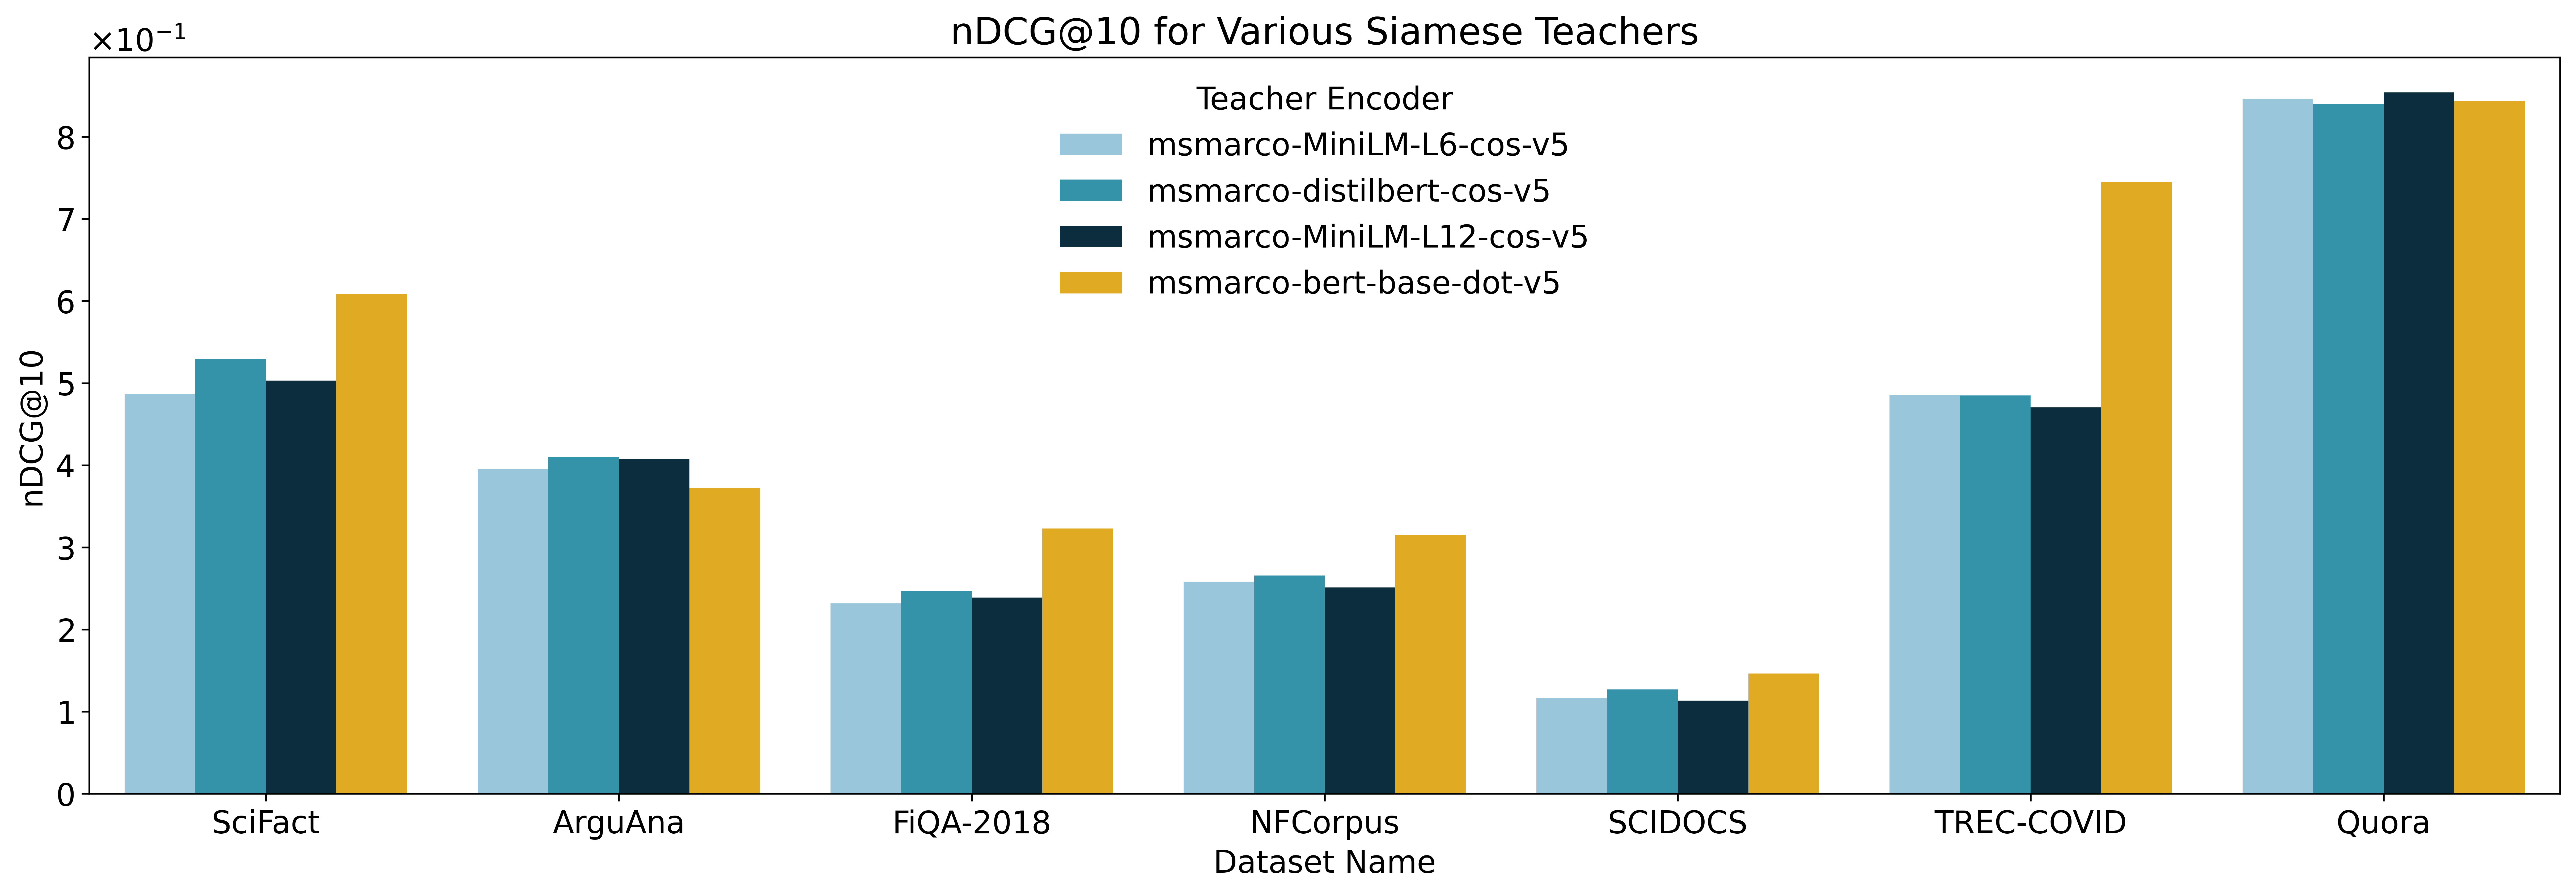

In [86]:
df_no_distill = pd.read_csv(DIR_EVAL / "eval_results_symmetric.csv")
df_no_distill["dataset_name"] = df_no_distill["dataset_name"].map(get_ds_name)

fig, ax = plt.subplots(figsize=(20, 6), dpi=600)
barplot = sns.barplot(data=df_no_distill,
                      x="dataset_name",
                      y="NDCG@10",
                      hue="document_encoder",
                      ax=ax)

ax.set_title("nDCG@10 for Various Siamese Teachers")
ax.set_xlabel("Dataset Name")
ax.set_ylabel("nDCG@10")
ax.legend(title="Teacher Encoder")

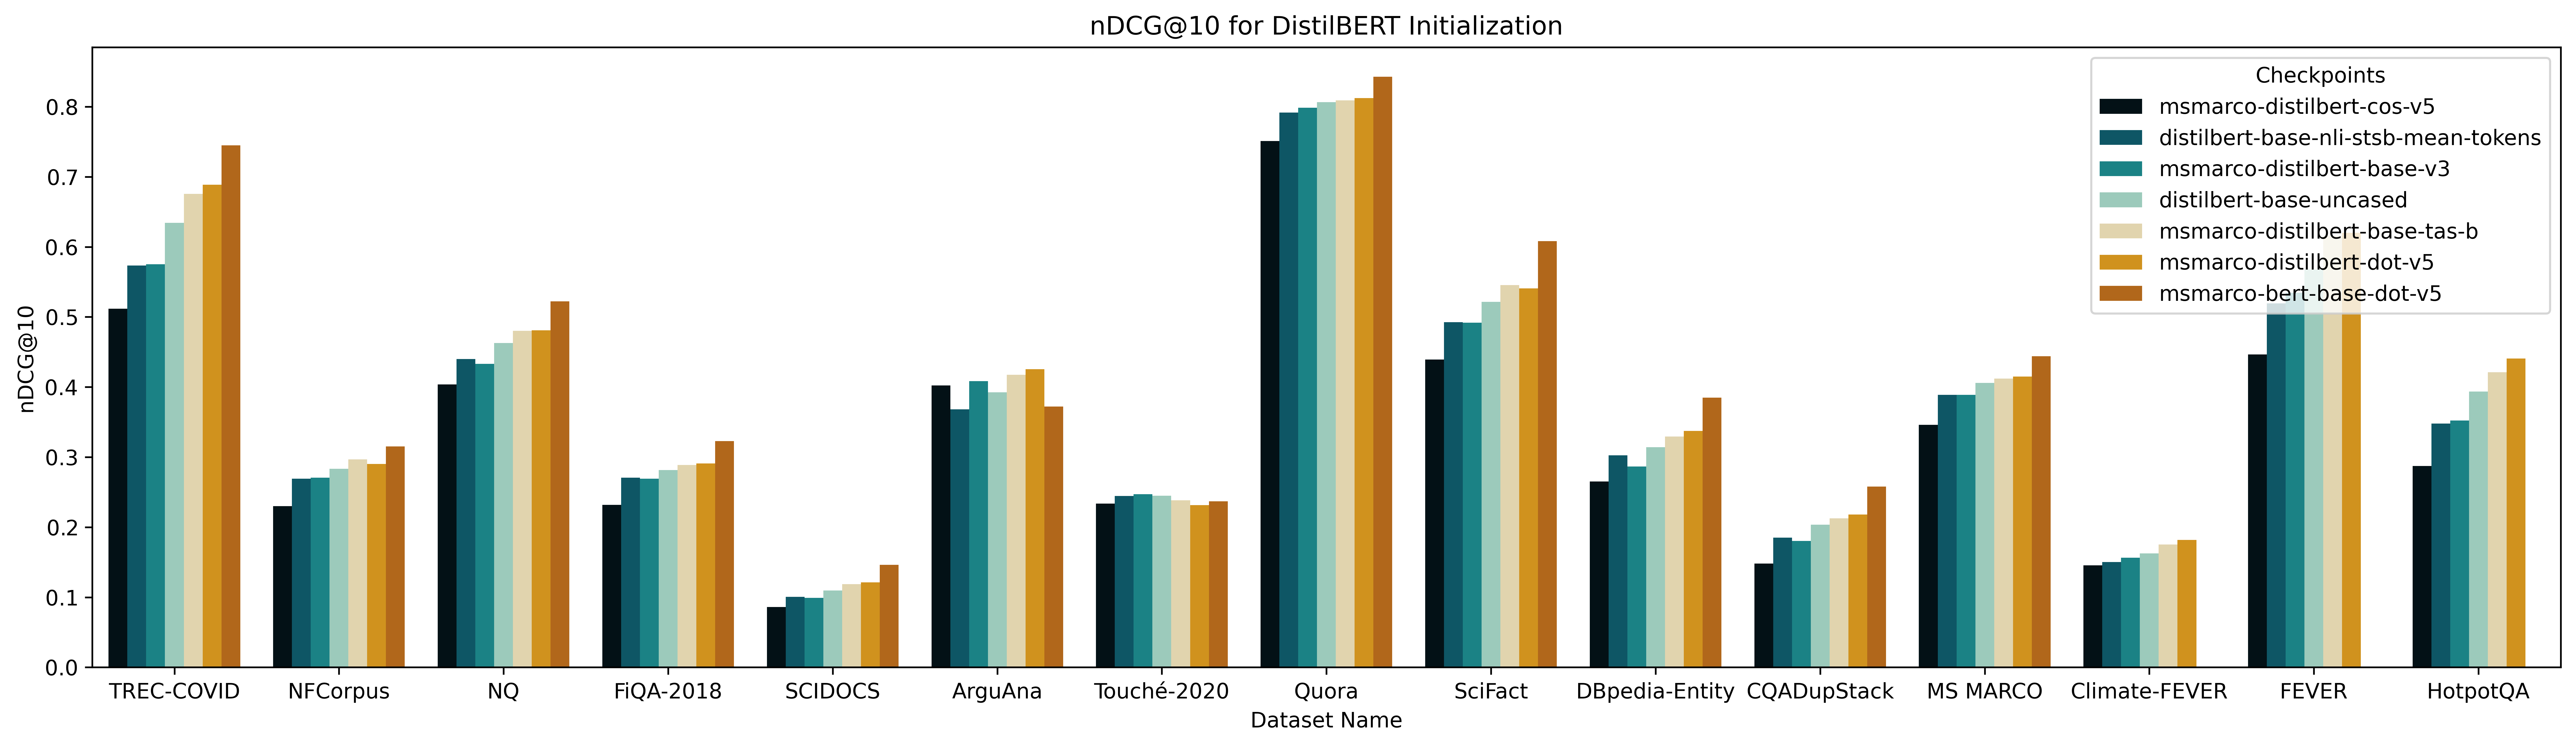

In [7]:
df_vis = pd.read_csv(DIR_EVAL / "eval_results_distilbert.csv").filter(regex=r"query_encoder|dataset_name|@")
df_vis["dataset_name"] = df_vis["dataset_name"].map(get_ds_name)

df_avg = df_vis.filter(regex=r"query_encoder|@") \
               .groupby(["query_encoder"]) \
               .mean() \
               .reset_index() \
               .assign(dataset_name="Average") \
               .sort_values("NDCG@10", ascending=True)

fig, ax = plt.subplots(figsize=(17, 5), dpi=600)
barplot = sns.barplot(data=df_vis,
                      x="dataset_name",
                      y="NDCG@10",
                      hue="query_encoder",
                      hue_order=df_avg["query_encoder"],
                      orient="v",
                      ax=ax)

ax.set_title("nDCG@10 for DistilBERT Initialization")
ax.set_xlabel("Dataset Name")
ax.set_ylabel("nDCG@10")
ax.legend(title="Checkpoints")

fig.tight_layout()

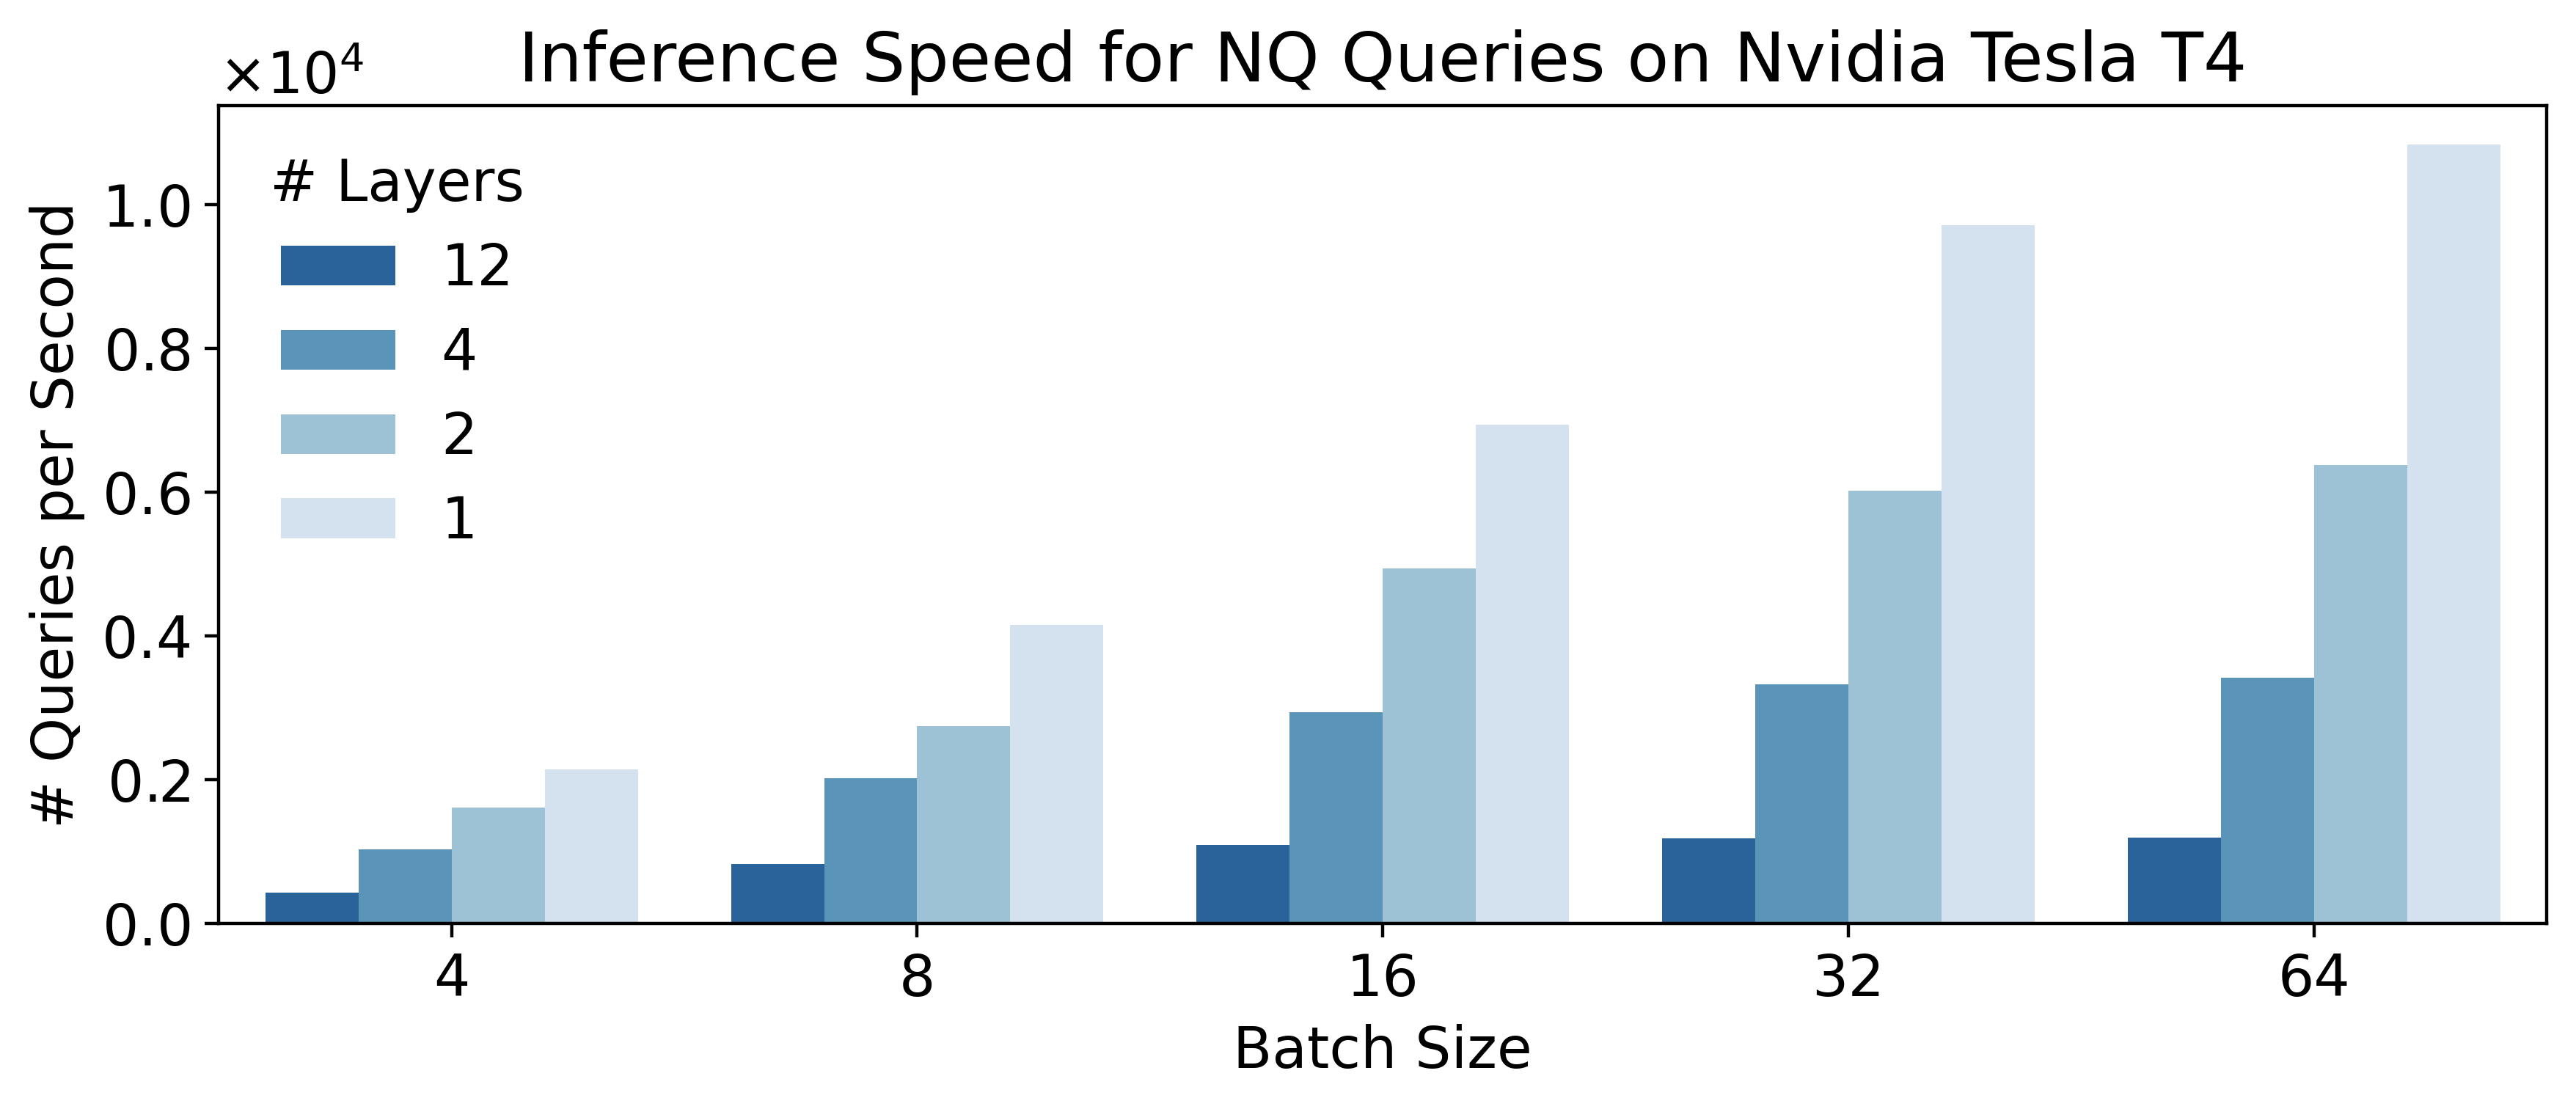

In [95]:
df_vis = pd.read_csv(DIR_EVAL / "inference_speed.csv")
df_vis = df_vis.assign(n_layers=df_vis["encoder"].map(get_num_layers))

fig, ax = plt.subplots(figsize=(9, 4), dpi=400)
sns.barplot(data=df_vis,
             x="batch_size",
             y="speed",
             hue="n_layers",
             hue_order=sorted(df_vis["n_layers"].unique())[::-1],
             estimator="median",
             errorbar=None,
             capsize=.03,
             errwidth=1.5,
             palette=sns.color_palette("Blues", n_colors=df_vis["n_layers"].nunique())[::-1],
             ax=ax)

# Scientific notation on y-axis
ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax.grid(False, axis="x")

ax.set_title("Inference Speed for NQ Queries on Nvidia Tesla T4")
ax.set_ylabel("# Queries per Second")
ax.set_xlabel("Batch Size")
ax.legend(title="# Layers")

fig.tight_layout()